In [61]:
import os
import json
from openai import OpenAI
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from typing import Annotated, TypedDict, Optional, List
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# API 키 정보 로드
load_dotenv()

api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [ ]:
# 1️⃣ State 정의 (missing_info 필드 추가)
class State(TypedDict):
    question: Annotated[List[str], add_messages]
    extracted_date: Annotated[str, "vacation date"]  # 연차 날짜
    leave_type: Annotated[str, "vacation type"]  # 연차 종류 (예: 연차, 반차 등)
    reason: Annotated[str, "vacation reason"]  # 연차 사유
    name: Annotated[str, "User's name"]  # 신청자 이름
    missing_info: Annotated[bool, "missing information"]  # 부족한 정보 여부
    answer: Annotated[str, "Answer"]  # 사용자 입력에 대한 답변
    messages: Annotated[list, add_messages]  # 대화 기록


def extract_info(user_input: str) -> dict:
    prompt = f"""
        아래 대화 내용에서 연차 신청에 필요한 정보를 추출하여 반드시 아래 JSON 형식으로만 출력하시오.
        출력 형식 (다른 텍스트 없이 오직 JSON 형식만 출력):
        {{
            "extracted_date": "YYYY.MM.DD",  // 날짜 (입력에 날짜가 없으면 null)
            "leave_type": "연차",           // 연차 종류 (연차, 반차, 병가, 출장, 휴가 등; 입력이 없으면 null)
            "reason": "사유",              // 연차 사유 (입력이 없으면 null)
            "name": "신청자 이름"           // 신청자 이름 (입력이 없으면 null)
        }}

        대화 내용:
        {user_input}
    """

    response = llm.invoke([{"role": "user", "content": prompt}])
    result_str = response.content.strip()
    print("LLM Raw Response:", result_str)  # 디버깅용 출력

    # 마크다운 코드 블록 제거 (예: ```json ... ```)
    if result_str.startswith("```"):
        lines = result_str.splitlines()
        if lines[0].startswith("```"):
            lines = lines[1:]
        if lines and lines[-1].strip() == "```":
            lines = lines[:-1]
        result_str = "\n".join(lines).strip()

    try:
        extracted_data = json.loads(result_str)
    except json.JSONDecodeError as e:
        raise ValueError(
            f"LLM 응답을 JSON으로 파싱하지 못했습니다: {result_str}"
        ) from e

    return extracted_data


def chatbot(state: State) -> State:
    # question이 리스트일 경우 마지막 요소의 content를 사용하고, 그렇지 않으면 직접 사용
    if isinstance(state["question"], list):
        user_input = state["question"][-1].content
    else:
        user_input = state["question"]

    extracted_data = extract_info(user_input)

    # 각 필드를 명시적으로 업데이트 (기존 값은 덮어씀)
    for key in ["extracted_date", "leave_type", "reason", "name"]:
        state[key] = extracted_data.get(key)

    # 부족한 정보가 있는지 True/False로 체크하여 missing_info에 저장
    missing_fields = [
        key
        for key in ["extracted_date", "leave_type", "reason", "name"]
        if not state.get(key)
    ]
    state["missing_info"] = bool(missing_fields)

    print("업데이트된 state:", state)

    return state


# 4️⃣ 부족한 정보를 모델이 질문하여 보완
def request_missing_info(state: State) -> State:
    prompts = {
        "extracted_date": "날짜를 입력해주세요. (예: 2025년 3월 17일)",
        "leave_type": "연차 종류를 입력해주세요. (연차, 반차, 병가 등)",
        "reason": "연차 사유를 입력해주세요.",
        "name": "이름을 입력해주세요.",
    }
    # 부족한 정보가 있다면 해당 프롬프트 출력 (여기서는 messages에 추가)
    for key, prompt in prompts.items():
        if not state.get(key):
            return {
                "messages": [{"role": "assistant", "content": prompt}],
            }
    return state


def update_missing_info(state: State) -> State:
    # 현재 부족한 필드 목록 확인
    missing_keys = [
        key
        for key in ["extracted_date", "leave_type", "reason", "name"]
        if not state.get(key)
    ]
    # 부족한 정보가 없으면 바로 응답 생성으로 분기
    if not missing_keys:
        return {"missing_info": False}

    print("부족한 정보를 입력해주세요. 예시: 2025년 3월 17일, 연차, 개인사정, 김철수")
    new_input = input(">> ")
    # 기존 question에 새 입력 병합 (이미 값이 채워진 필드는 유지)
    state["question"] += " " + new_input

    extracted_data = extract_info(state["question"])
    # 새로 추출된 값 중, 기존에 비어있는 필드만 업데이트
    for key in missing_keys:
        if extracted_data.get(key):
            state[key] = extracted_data.get(key)

    # 다시 부족한 필드 확인
    missing_keys = [
        key
        for key in ["extracted_date", "leave_type", "reason", "name"]
        if not state.get(key)
    ]
    state["missing_info"] = bool(missing_keys)
    return state


# 6️⃣ 최종 응답을 생성하는 챗봇
def response_bot(state: State) -> State:
    latest_question = state["question"][-1].content
    response_text = (
        f"날짜: {state['extracted_date']}\n"
        f"종류: {state['leave_type']}\n"
        f"사유: {state['reason']}\n"
        f"이름: {state['name']}"
    )
    extracted_data = extract_info(latest_question)  # 최종 입력에 대해 정보 추출

    # 각 필드를 명시적으로 업데이트 (기존 값은 덮어씀)
    for key in ["extracted_date", "leave_type", "reason", "name"]:
        state[key] = extracted_data.get(key)

    return {
        "answer": response_text,
        "messages": [{"role": "assistant", "content": response_text}],
    }

In [ ]:
# 예시 조건 함수: state["missing_info"]가 True이면 "update_missing_info", False이면 "response_bot"를 반환
def missing_info(state: State) -> str:
    return "update_missing_info" if state.get("missing_info") else "response_bot"


# 그래프 생성
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)  # 사용자 입력 분석
graph_builder.add_node("request_missing_info", request_missing_info)  # 부족한 정보 질문
graph_builder.add_node("update_missing_info", update_missing_info)  # 사용자 응답 반영
graph_builder.add_node("response_bot", response_bot)  # 최종 응답 생성

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", "request_missing_info")
# 조건부 엣지: request_missing_info 노드에서 missing_info 값에 따라 분기 (문자열 키 사용)
graph_builder.add_conditional_edges(
    "request_missing_info",
    missing_info,
    {
        "update_missing_info": "update_missing_info",
        "response_bot": "response_bot",
    },
)
graph_builder.add_conditional_edges(
    "update_missing_info",
    missing_info,
    {
        "update_missing_info": "request_missing_info",
        "response_bot": "response_bot",
    },
)
graph_builder.add_edge("response_bot", END)

graph = graph_builder.compile()

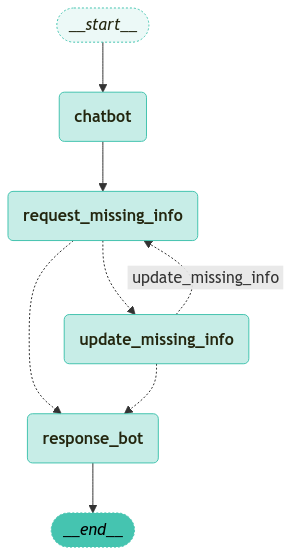

In [97]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [98]:
from langchain_core.runnables import RunnableConfig

# 그래프 실행
question = "2025년 3월 17일에 개인사정으로 연차를 사용할게."

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, thread_id=0)


for event in graph.stream(
    {
        "question": question,
        "messages": [("user", question)],
        "extracted_date": None,
        "leave_type": None,
        "reason": None,
        "name": None,
        "missing_info": None,
    }
):
    for value in event.values():
        print("Assistant:", value["messages"])

LLM Raw Response: ```json
{
    "extracted_date": "2025.03.17",
    "leave_type": "연차",
    "reason": "개인사정",
    "name": null
}
```
업데이트된 state: {'question': [HumanMessage(content='2025년 3월 17일에 개인사정으로 연차를 사용할게.', additional_kwargs={}, response_metadata={}, id='3c164f6a-0867-4cd4-b912-8a2169e1ce82')], 'extracted_date': '2025.03.17', 'leave_type': '연차', 'reason': '개인사정', 'name': None, 'missing_info': True, 'messages': [HumanMessage(content='2025년 3월 17일에 개인사정으로 연차를 사용할게.', additional_kwargs={}, response_metadata={}, id='ce0e32a0-cb26-4d0d-a529-27394fcff88d')]}
Assistant: [HumanMessage(content='2025년 3월 17일에 개인사정으로 연차를 사용할게.', additional_kwargs={}, response_metadata={}, id='ce0e32a0-cb26-4d0d-a529-27394fcff88d')]
Assistant: [{'role': 'assistant', 'content': '이름을 입력해주세요.'}]
부족한 정보를 입력해주세요. 예시: 2025년 3월 17일, 연차, 개인사정, 김철수
LLM Raw Response: ```json
{
    "extracted_date": "2025.03.17",
    "leave_type": "연차",
    "reason": "개인사정",
    "name": "김은오"
}
```
Assistant: [HumanMessage(content='2

In [99]:
!pip install fastapi uvicorn


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
###### FastAPI 엔드포인트 구성 ######
from fastapi import FastAPI
from pydantic import BaseModel

app = FastAPI()


# 백엔드로부터 question 값을 받을 요청 모델
class ChatRequest(BaseModel):
    question: str


@app.post("/api/v1/ask")
def ask_chatbot(request: ChatRequest):
    # 백엔드로부터 전달받은 question을 사용하여 초기 state 구성
    initial_state = {
        "question": request.question,
        "messages": [("user", request.question)],
        "extracted_date": None,
        "leave_type": None,
        "reason": None,
        "name": None,
        "missing_info": None,
        "answer": None,
    }
    config = RunnableConfig(recursion_limit=10, thread_id=0)
    final_state = None
    # 그래프 실행 (여기서는 동기 방식 사용)
    for event in graph.stream(initial_state, config=config):
        # 이벤트 결과 중 마지막 state를 final_state에 저장
        final_state = event
    if final_state is None or not final_state.get("messages"):
        raise HTTPException(status_code=500, detail="No response from model.")
    # 최종 메시지들 반환 (대화 내역 혹은 answer 필드)
    return {
        "answer": final_state.get("answer"),
        "messages": final_state.get("messages"),
    }